# **Initialization**

In [ ]:
import os
import random
import shutil
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

In [1]:
import torch

if torch.cuda.is_available():
    print("GPU is enabled and available!")
    print("Device Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available. Please check runtime settings.")


GPU is enabled and available!
Device Name: Tesla P100-PCIE-16GB


# **DenseNet121**

## **Import Libraries and Set Random Seeds**

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121
from keras.models import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## **Define Dataset Paths and Parameters**

In [3]:
# Dataset paths
BASE_DIR = '/kaggle/input/robo-dataset-h/robo_dataset_ha'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

## **Data Preprocessing and Augmentation**

In [4]:
# Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1964 images belonging to 3 classes.
Found 275 images belonging to 3 classes.
Found 138 images belonging to 3 classes.


## **Build and Compile the Model**

In [5]:
# Load DenseNet-121 base model
densenet_base = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Define the model
model = Sequential([
    densenet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes: Healthy, ROP, RD
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ]
)

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,040,579 (26.86 MB)

 Trainable params: 6,956,931 (26.54 MB)

 Non-trainable params: 83,648 (326.75 KB)

## **Set Up Model Checkpoints**

In [6]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

## **Train the Model**

In [7]:
# Train the Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7924 - auc: 0.9147 - loss: 0.6425 - precision: 0.7970 - recall: 0.7845
Epoch 1: val_loss improved from inf to 1.50569, saving model to best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.7933 - auc: 0.9153 - loss: 0.6397 - precision: 0.7979 - recall: 0.7855 - val_accuracy: 0.6873 - val_auc: 0.8868 - val_loss: 1.5057 - val_precision: 0.6873 - val_recall: 0.6873
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.9249 - auc: 0.9856 - loss: 0.2161 - precision: 0.9297 - recall: 0.9235
Epoch 2: val_loss improved from 1.50569 to 0.39193, saving model to best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 432ms/step - accuracy: 0.9248 - auc: 0.9856 - loss: 0.2163 - precision: 0.9296 - recall: 0.9235 - val_accuracy: 0.8945 - val_auc: 0.9607 - val_loss: 0.3919 - val_precision: 0.8945 - val_recall: 0.8945
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9178 - auc: 0.9829 - loss: 0.2337 - precision:

## **Plot Training History**

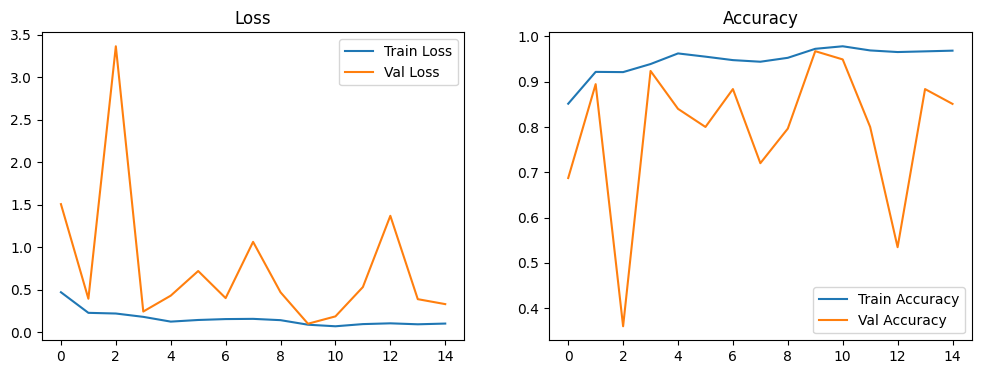

In [8]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## **Evaluate the Model on Test Data**

In [9]:
# Evaluate on Test Data
model.load_weights('best_model.keras')
evaluation_metrics = model.evaluate(test_generator)

# Unpack metrics
test_loss, test_accuracy, test_precision, test_recall, test_auc = evaluation_metrics

# Print metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9256 - auc: 0.9722 - loss: 0.3703 - precision: 0.9256 - recall: 0.9256 
Test Loss: 0.2521
Test Accuracy: 0.9565
Test Precision: 0.9565
Test Recall: 0.9565
Test AUC: 0.9834


## **Generate Classification Report and Confusion Matrix**

5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00         3
          RD       0.98      0.95      0.97        44
         ROP       0.95      0.99      0.97        91

    accuracy                           0.96       138
   macro avg       0.64      0.65      0.64       138
weighted avg       0.94      0.96      0.95       138


Confusion Matrix:
[[ 0  0  3]
 [ 0 42  2]
 [ 0  1 90]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


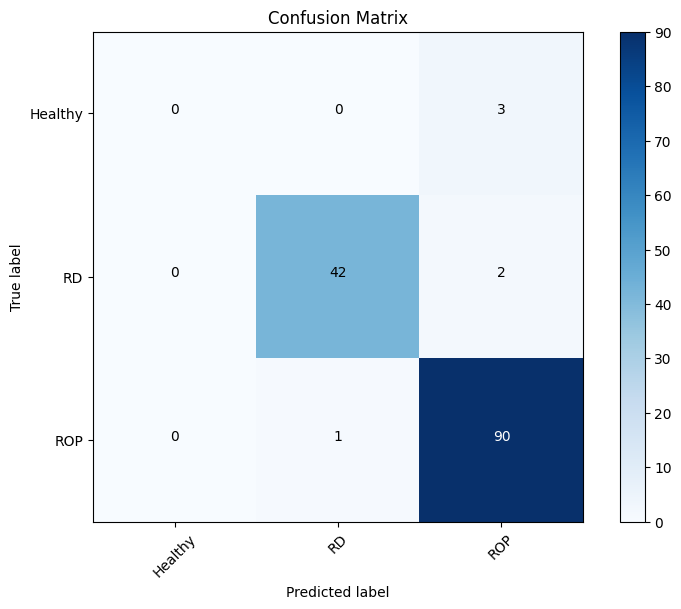

In [10]:
# Generate Classification Report
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [11]:
# Save the Model
#SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')

# Change the save directory to a writable location
SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save the model
model_path = os.path.join(SAVE_DIR, 'densenet_rop_model_ha.h5')
model.save(model_path)

print(f"Model saved at: {model_path}")

Model saved at: /kaggle/working/saved_models/densenet_rop_model_ha.h5


# **EfficientNetB0**

## **Imports and Setup**

In [12]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetB0
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## **Dataset Paths and Parameters**

In [13]:
# Path to dataset folders
BASE_DIR = '/kaggle/input/robo-dataset-h/robo_dataset_ha'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

## **Data Augumentation and Preprocessing**

In [14]:
# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1964 images belonging to 3 classes.
Found 275 images belonging to 3 classes.
Found 138 images belonging to 3 classes.


## **Model Building**

In [15]:
# Build the Model
efficientnet_base = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

model = Sequential([
    efficientnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # Adjust the number of classes as per your dataset (e.g., 3 for Healthy, ROP, RD)
])

# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           3,843 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 4,011,391 (15.30 MB)

 Non-trainable params: 42,023 (164.16 KB)

## **Training**

In [16]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_rop_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Train the Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 920ms/step - accuracy: 0.5886 - auc: 0.7637 - loss: 0.8770 - precision: 0.6670 - recall: 0.3787
Epoch 1: val_loss improved from inf to 0.82231, saving model to best_rop_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.5910 - auc: 0.7658 - loss: 0.8735 - precision: 0.6695 - recall: 0.3824 - val_accuracy: 0.6836 - val_auc: 0.8415 - val_loss: 0.8223 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.8974 - auc: 0.9701 - loss: 0.3261 - precision: 0.9050 - recall: 0.8782
Epoch 2: val_loss improved from 0.82231 to 0.79749, saving model to best_rop_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 399ms/step - accuracy: 0.8975 - auc: 0.9702 - loss: 0.3255 - precision: 0.9052 - recall: 0.8785 - val_accuracy: 0.6836 - val_auc: 0.8347 - val_loss: 0.7975 - val_precision: 0.6836 - val_recall: 0.6836
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9436 - auc: 0.9909 - loss: 

## **Plot Training History**

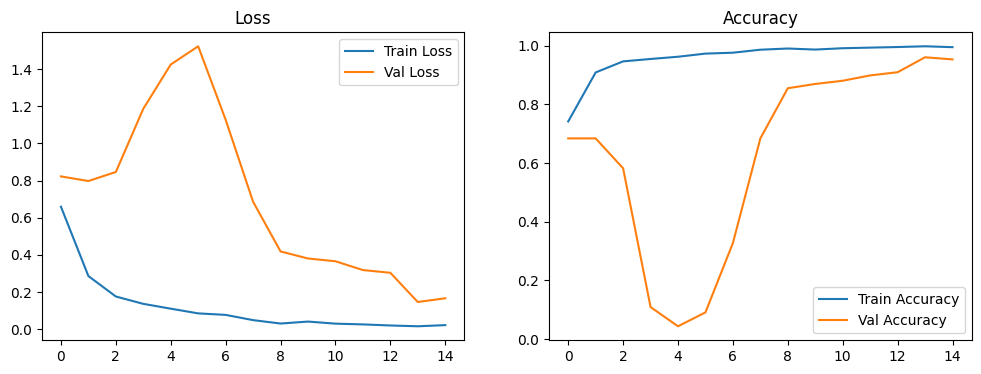

In [17]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## **Evaluation on Test Data**

In [18]:
# Evaluate on Test Data
model.load_weights('best_rop_model.keras')
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8910 - auc: 0.9566 - loss: 0.4400 - precision: 0.8910 - recall: 0.8910
Test Loss: 0.2778
Test Accuracy: 0.9348
Test Precision: 0.9348
Test Recall: 0.9348
Test AUC: 0.9779


## **Classification Report and Confusion Matrix**

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00         3
          RD       0.00      0.00      0.00        44
         ROP       0.66      1.00      0.79        91

    accuracy                           0.66       138
   macro avg       0.22      0.33      0.26       138
weighted avg       0.43      0.66      0.52       138


Confusion Matrix:
[[ 0  0  3]
 [ 0  0 44]
 [ 0  0 91]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


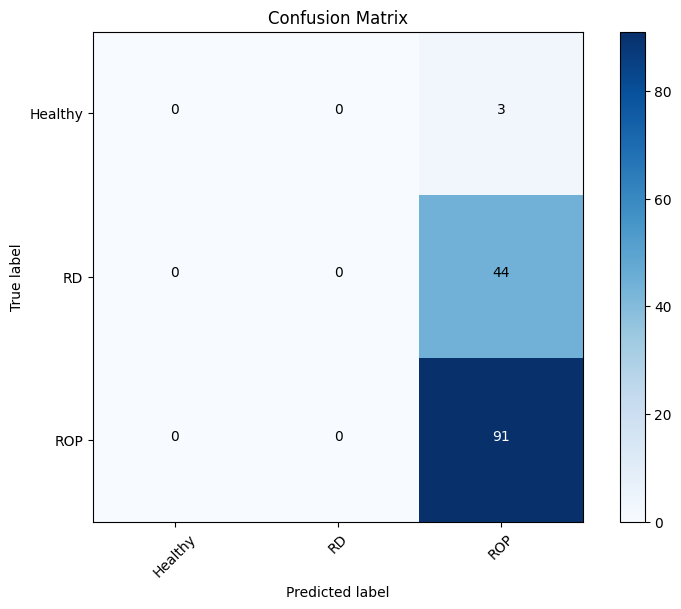

In [19]:
# Generate Classification Report
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [20]:
# Save the Model
#SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')

# Change the save directory to a writable location
SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

model_path = os.path.join(SAVE_DIR, 'efficientnet_rop_model_ha.h5')
model.save(model_path)

print(f"Model saved to {model_path}")

Model saved to /kaggle/working/saved_models/efficientnet_rop_model_ha.h5


# **Xception**

## **Import Libraries and Set Up Parameters**


In [21]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Path to dataset folders
BASE_DIR = '/kaggle/input/robo-dataset-h/robo_dataset_ha'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

## **Data Augmentation and Preprocessing**

In [22]:
# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1964 images belonging to 3 classes.
Found 275 images belonging to 3 classes.
Found 138 images belonging to 3 classes.


## **Build the Model**

In [24]:
# Build the Model
xception_base = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

model = Sequential([
    xception_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # Adjust for your number of classes
])

# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,867,627 (79.60 MB)

 Trainable params: 20,813,099 (79.40 MB)

 Non-trainable params: 54,528 (213.00 KB)

## **Train the Model**

In [25]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_xception_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Train the Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.6038 - auc: 0.7070 - loss: 0.9308 - precision: 0.6280 - recall: 0.2543
Epoch 1: val_loss improved from inf to 0.25938, saving model to best_xception_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 103s 874ms/step - accuracy: 0.6069 - auc: 0.7104 - loss: 0.9254 - precision: 0.6325 - recall: 0.2594 - val_accuracy: 0.9382 - val_auc: 0.9844 - val_loss: 0.2594 - val_precision: 0.9375 - val_recall: 0.9273
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9429 - auc: 0.9917 - loss: 0.1625 - precision: 0.9465 - recall: 0.9409
Epoch 2: val_loss improved from 0.25938 to 0.10940, saving model to best_xception_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 29s 424ms/step - accuracy: 0.9430 - auc: 0.9917 - loss: 0.1623 - precision: 0.9466 - recall: 0.9410 - val_accuracy: 0.9564 - val_auc: 0.9975 - val_loss: 0.1094 - val_precision: 0.9703 - val_recall: 0.9491
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.9689 - auc: 0.9970 - l

## **Plot Training History**

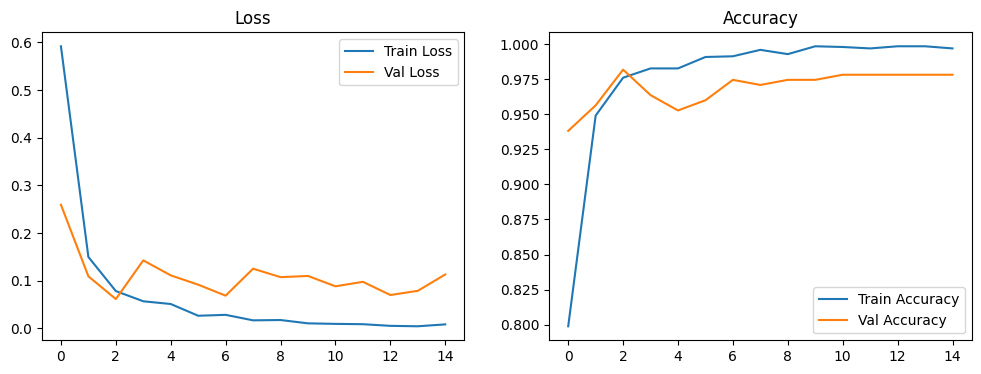

In [26]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## **Evaluate the Model**

In [27]:
# Evaluate the Model
model.load_weights('best_xception_model.keras')

test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 734ms/step - accuracy: 0.9308 - auc: 0.9940 - loss: 0.1459 - precision: 0.9559 - recall: 0.9308
Test Loss: 0.1071
Test Accuracy: 0.9565
Test Precision: 0.9706
Test Recall: 0.9565
Test AUC: 0.9970


## **Classification Report and Confusion Matrix**

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 595ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      0.67      0.80         3
          RD       0.98      0.91      0.94        44
         ROP       0.95      0.99      0.97        91

    accuracy                           0.96       138
   macro avg       0.97      0.85      0.90       138
weighted avg       0.96      0.96      0.96       138


Confusion Matrix:
[[ 2  0  1]
 [ 0 40  4]
 [ 0  1 90]]


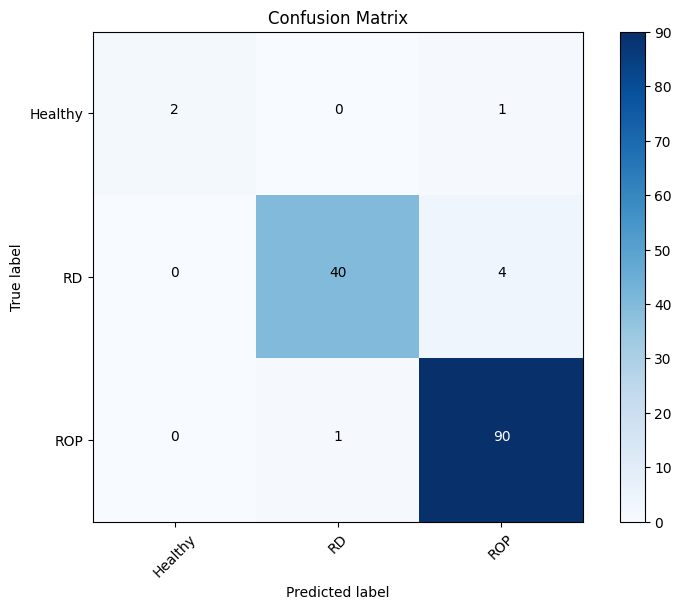

In [28]:
# Generate Classification Report
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [29]:
# Save the Model
#SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')

# Change the save directory to a writable location
SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

model_path = os.path.join(SAVE_DIR, 'xception_rop_model_ha.h5')
model.save(model_path)

print(f"Model saved to {model_path}")

Model saved to /kaggle/working/saved_models/xception_rop_model_ha.h5


# **InceptionV3**

## **Import Libraries and Set Up Parameters**


In [31]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3
from keras.models import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Path to dataset folders
BASE_DIR = '/kaggle/input/robo-dataset-h/robo_dataset_ha'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

## **Data Augmentation and Preprocessing**

In [32]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1964 images belonging to 3 classes.
Found 275 images belonging to 3 classes.
Found 138 images belonging to 3 classes.


## **Build Model**

In [33]:
inception_base = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

model = Sequential([
    inception_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes: Healthy, ROP, RD
])

# Compile the model with additional metrics
model.compile(
    optimizer="adam",  # or any optimizer of your choice
    loss="categorical_crossentropy",  # or any loss function suitable for your problem
    metrics=[
        "accuracy",  # default metric
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ],
)

# Display the model architecture
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,808,931 (83.19 MB)

 Trainable params: 21,774,499 (83.06 MB)

 Non-trainable params: 34,432 (134.50 KB)

## **Train Model**

In [34]:
checkpoint = ModelCheckpoint(
    'best_inception_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Train the Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 962ms/step - accuracy: 0.7793 - auc: 0.9021 - loss: 0.6116 - precision: 0.8015 - recall: 0.7641
Epoch 1: val_loss improved from inf to 0.91456, saving model to best_inception_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.7807 - auc: 0.9030 - loss: 0.6082 - precision: 0.8026 - recall: 0.7655 - val_accuracy: 0.7164 - val_auc: 0.8824 - val_loss: 0.9146 - val_precision: 0.7164 - val_recall: 0.7164
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9310 - auc: 0.9882 - loss: 0.1918 - precision: 0.9344 - recall: 0.9256
Epoch 2: val_loss improved from 0.91456 to 0.46796, saving model to best_inception_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 411ms/step - accuracy: 0.9310 - auc: 0.9881 - loss: 0.1920 - precision: 0.9344 - recall: 0.9256 - val_accuracy: 0.8182 - val_auc: 0.9517 - val_loss: 0.4680 - val_precision: 0.8182 - val_recall: 0.8182
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9283 - auc: 0.9881 - lo

## **Plotting Training History**

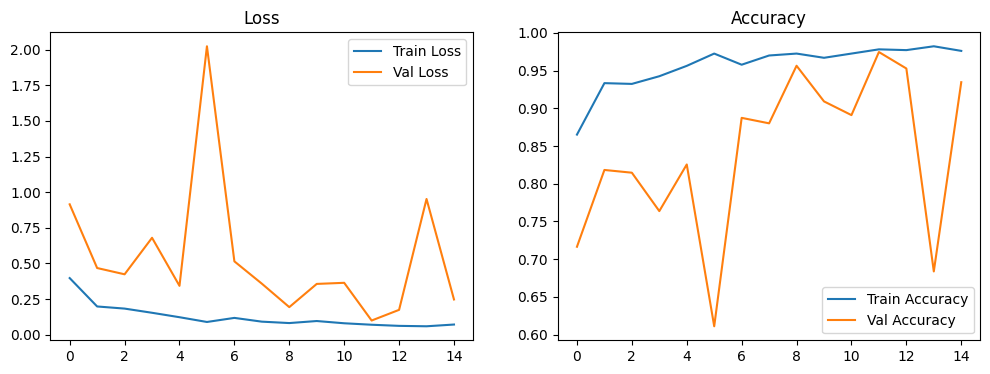

In [35]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## **Evaluate on Test data**

In [36]:
model.load_weights('best_inception_model.keras')
# test_loss, test_accuracy = model.evaluate(test_generator)
# print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
# model.load_weights('best_xception_model.keras')

test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")



5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9308 - auc: 0.9839 - loss: 0.2361 - precision: 0.9308 - recall: 0.9308
Test Loss: 0.1528
Test Accuracy: 0.9565
Test Precision: 0.9565
Test Recall: 0.9565
Test AUC: 0.9918


## **Classification Report and Confusion Matrix**

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step 

Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00         3
          RD       0.97      0.89      0.93        44
         ROP       0.95      0.99      0.97        91

    accuracy                           0.96       138
   macro avg       0.97      0.96      0.97       138
weighted avg       0.96      0.96      0.96       138


Confusion Matrix:
[[ 3  0  0]
 [ 0 39  5]
 [ 0  1 90]]


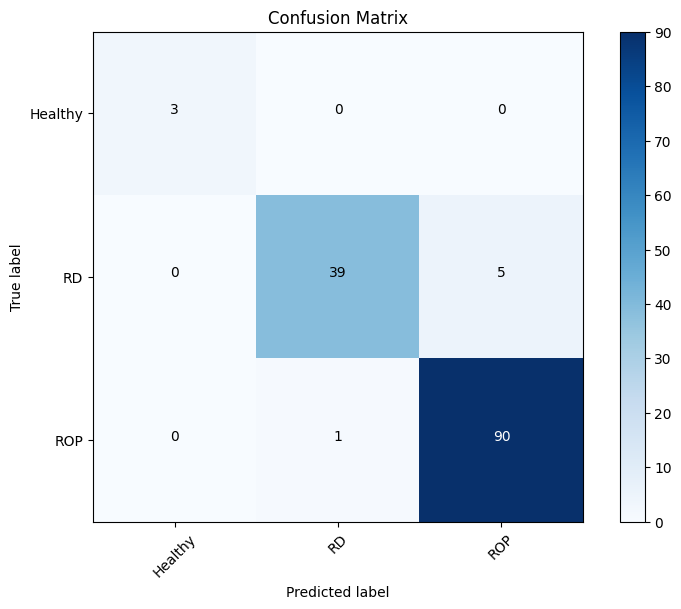

In [37]:
# Generate Classification Report
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [38]:
# Save the Model
#SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')

# Change the save directory to a writable location
SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

model_path = os.path.join(SAVE_DIR, 'inceptionv3_rop_model_ha.h5')
model.save(model_path)

print(f"Model saved to {model_path}")

Model saved to /kaggle/working/saved_models/inceptionv3_rop_model_ha.h5


# **MobileNetV3**

## **Import Libraries and Set Up Parameters**



In [39]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV3Large
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Path to dataset folders
BASE_DIR = '/kaggle/input/robo-dataset-h/robo_dataset_ha'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

## **Data Augmentation and Preprocessing**

In [40]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 1964 images belonging to 3 classes.
Found 275 images belonging to 3 classes.
Found 138 images belonging to 3 classes.


## **Build Model**

In [41]:
mobilenetv3_base = MobileNetV3Large(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

model = Sequential([
    mobilenetv3_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes: Healthy, ROP, RD
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

model.summary()




12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)        │ (None, 7, 7, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 960)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 960)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │           2,883 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,999,235 (11.44 MB)

 Trainable params: 2,974,835 (11.35 MB)

 Non-trainable params: 24,400 (95.31 KB)

## **Train the Model**

In [42]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_mobilenetv3_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.6835 - auc: 0.8433 - loss: 0.7445 - precision: 0.7067 - recall: 0.6250
Epoch 1: val_loss improved from inf to 1.37757, saving model to best_mobilenetv3_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 109s 923ms/step - accuracy: 0.6851 - auc: 0.8445 - loss: 0.7413 - precision: 0.7083 - recall: 0.6271 - val_accuracy: 0.3018 - val_auc: 0.3075 - val_loss: 1.3776 - val_precision: 0.2895 - val_recall: 0.0800
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.9046 - auc: 0.9795 - loss: 0.2689 - precision: 0.9135 - recall: 0.8999
Epoch 2: val_loss did not improve from 1.37757
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 372ms/step - accuracy: 0.9048 - auc: 0.9796 - loss: 0.2685 - precision: 0.9137 - recall: 0.9001 - val_accuracy: 0.2982 - val_auc: 0.3092 - val_loss: 1.3913 - val_precision: 0.2703 - val_recall: 0.1091
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9486 - auc: 0.9932 - loss: 0.1513 - precision: 0.9498 - recall: 0.

## **Plotting Training History**

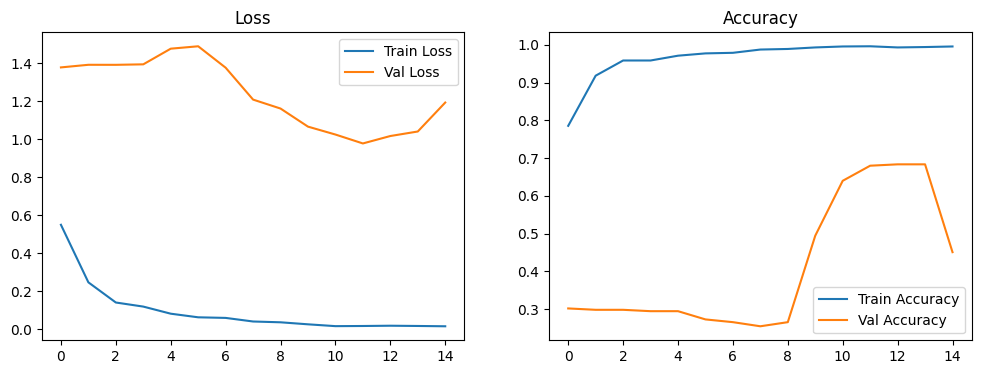

In [43]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## **Evaluate on Test Data**

In [44]:
model.load_weights('best_mobilenetv3_model.keras')
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Calculate and print mean training accuracy
mean_train_accuracy = np.mean(history.history['accuracy'])
print(f"Mean Training Accuracy: {mean_train_accuracy:.4f}")

# Calculate and print mean validation accuracy
mean_val_accuracy = np.mean(history.history['val_accuracy'])
print(f"Mean Validation Accuracy: {mean_val_accuracy:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 949ms/step - accuracy: 0.4546 - auc: 0.4910 - loss: 1.1818 - precision: 0.5304 - recall: 0.3071     
Test Loss: 0.9918
Test Accuracy: 0.6594
Test Precision: 0.7439
Test Recall: 0.4420
Test AUC: 0.6880
Mean Training Accuracy: 0.9664
Mean Validation Accuracy: 0.4119


## **Classification Report and Confusion Matrix**

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 927ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00         3
          RD       0.00      0.00      0.00        44
         ROP       0.66      1.00      0.79        91

    accuracy                           0.66       138
   macro avg       0.22      0.33      0.26       138
weighted avg       0.43      0.66      0.52       138


Confusion Matrix:
[[ 0  0  3]
 [ 0  0 44]
 [ 0  0 91]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


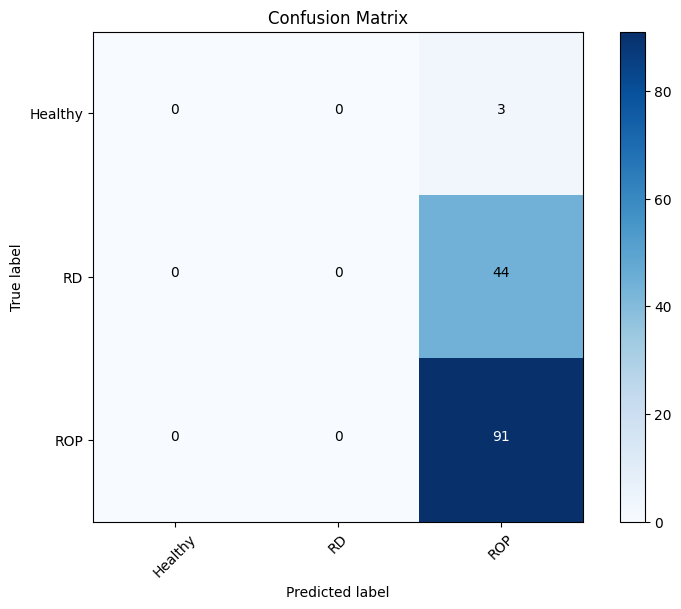

In [45]:
# Generate Classification Report
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [46]:
# Save the Model
#SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')

# Change the save directory to a writable location
SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save the model
model_path = os.path.join(SAVE_DIR, 'mobilenetv3_rop_model_ha.h5')
model.save(model_path)

print(f"Model saved at: {model_path}")

Model saved at: /kaggle/working/saved_models/mobilenetv3_rop_model_ha.h5


# **VGG16**


## **Import Libraries and Set Up parameters**

In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Path to dataset folders
BASE_DIR = '/kaggle/input/robo-dataset-h/robo_dataset_ha'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

## **Data Augmentation and Preprocessing**

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1964 images belonging to 3 classes.
Found 275 images belonging to 3 classes.
Found 138 images belonging to 3 classes.


## **Build the Model**

In [8]:
vgg_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Add custom layers on top
model = Sequential([
    vgg_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes: Healthy, ROP, RD
])

# Compile the model
model.compile(
    optimizer="adam",  # Can experiment with other optimizers like SGD
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,716,227 (56.14 MB)

 Trainable params: 14,716,227 (56.14 MB)

 Non-trainable params: 0 (0.00 B)

## **Train the Model**

In [9]:
checkpoint = ModelCheckpoint(
    'best_vgg_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Train the Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)


Epoch 1/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.6144 - auc_2: 0.7945 - loss: 1.7664 - precision_2: 0.6464 - recall_2: 0.5363
Epoch 1: val_loss improved from inf to 0.72690, saving model to best_vgg_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 59s 570ms/step - accuracy: 0.6152 - auc_2: 0.7949 - loss: 1.7551 - precision_2: 0.6469 - recall_2: 0.5372 - val_accuracy: 0.6836 - val_auc_2: 0.8664 - val_loss: 0.7269 - val_precision_2: 0.6836 - val_recall_2: 0.6836
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.7085 - auc_2: 0.8422 - loss: 0.7307 - precision_2: 0.7051 - recall_2: 0.6479
Epoch 2: val_loss improved from 0.72690 to 0.70451, saving model to best_vgg_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 386ms/step - accuracy: 0.7085 - auc_2: 0.8422 - loss: 0.7306 - precision_2: 0.7052 - recall_2: 0.6484 - val_accuracy: 0.6836 - val_auc_2: 0.8701 - val_loss: 0.7045 - val_precision_2: 0.6836 - val_recall_2: 0.6836
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step 

## **Plotting training History**

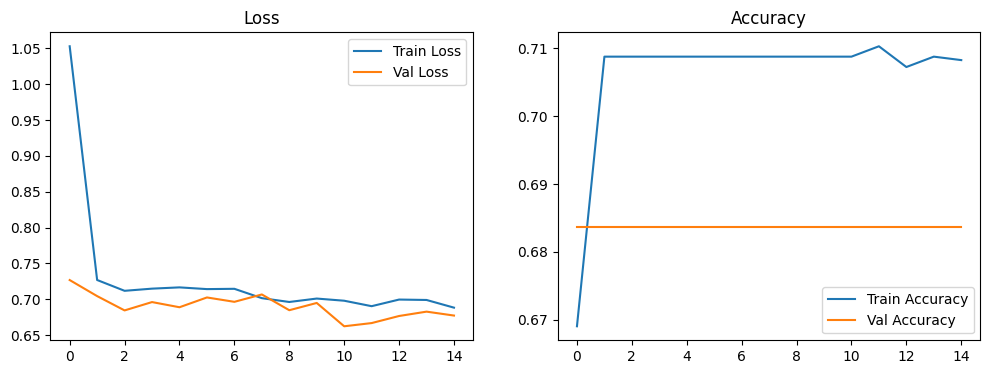

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()


## **Evaluate on Test Data**

In [11]:
model.load_weights('best_vgg_model.keras')
evaluation_metrics = model.evaluate(test_generator)

# Unpack metrics
test_loss, test_accuracy, test_precision, test_recall, test_auc = evaluation_metrics

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Calculate and print mean training accuracy
mean_train_accuracy = np.mean(history.history['accuracy'])
print(f"Mean Training Accuracy: {mean_train_accuracy:.4f}")

# Calculate and print mean validation accuracy
mean_val_accuracy = np.mean(history.history['val_accuracy'])
print(f"Mean Validation Accuracy: {mean_val_accuracy:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 868ms/step - accuracy: 0.4546 - auc_2: 0.7378 - loss: 0.9428 - precision_2: 0.4546 - recall_2: 0.4546      
Test Loss: 0.7088
Test Accuracy: 0.6594
Test Precision: 0.6594
Test Recall: 0.6594
Test AUC: 0.8599
Mean Training Accuracy: 0.7061
Mean Validation Accuracy: 0.6836


## **Classification Report and Confusion Matrix**

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00         3
          RD       0.00      0.00      0.00        44
         ROP       0.66      1.00      0.79        91

    accuracy                           0.66       138
   macro avg       0.22      0.33      0.26       138
weighted avg       0.43      0.66      0.52       138


Confusion Matrix:
[[ 0  0  3]
 [ 0  0 44]
 [ 0  0 91]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


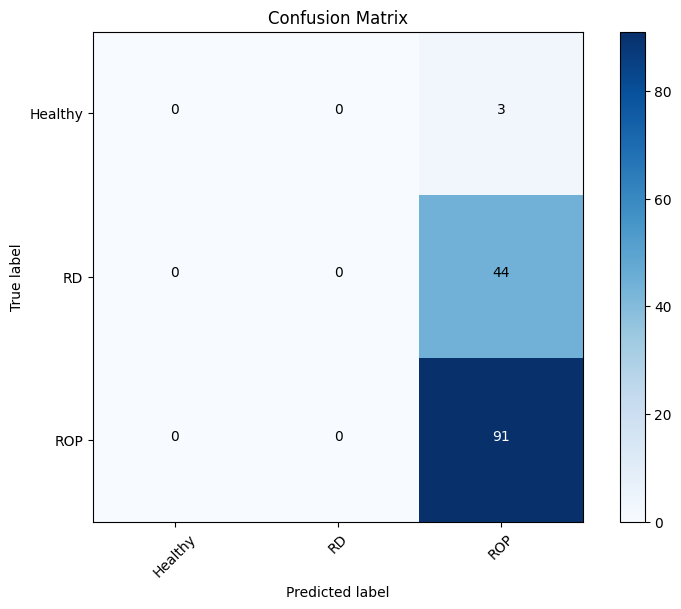

In [12]:
# Generate Classification Report
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [13]:
# Save the Model
#SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')

# Change the save directory to a writable location
SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save the model
model_path = os.path.join(SAVE_DIR, 'vgg16_rop_model_ha.h5')
model.save(model_path)

print(f"Model saved at: {model_path}")

Model saved at: /kaggle/working/saved_models/vgg16_rop_model_ha.h5


# **setting up dataset (not needed)**

In [ ]:
# Install and download dataset
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="CdeZJVrKXJQvsNCBSvks")
project = rf.workspace("airop").project("rop-vj9t0")
version = project.version(3)
dataset = version.download("folder")


# **EfficientNetV2-L**

## **Import Libraries**

In [57]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetV2L
from keras.models import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## **Set Up Parameters**

In [58]:
# Dataset paths
BASE_DIR = '/kaggle/input/robo-dataset-h/robo_dataset_ha'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15


## **Data Preprocessing and Augmentation**

In [59]:
# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1964 images belonging to 3 classes.
Found 275 images belonging to 3 classes.
Found 138 images belonging to 3 classes.


## **Build Function**

In [60]:
# Build and Compile the Model
# Load EfficientNetV2L
regnet_base = EfficientNetV2L(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Define the model
model = Sequential([
    regnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # Adjust the number of classes
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ]
)

model.summary()

473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-l (Functional)        │ (None, 7, 7, 1280)          │     117,746,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │           3,843 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,750,691 (449.18 MB)

 Trainable params: 117,238,115 (447.23 MB)

 Non-trainable params: 512,576 (1.96 MB)

## **Train Model**

In [61]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_efficientnetv2_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Train the Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7562 - auc: 0.8900 - loss: 0.6096 - precision: 0.8132 - recall: 0.6987
Epoch 1: val_loss improved from inf to 1.48447, saving model to best_efficientnetv2_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 528s 4s/step - accuracy: 0.7572 - auc: 0.8907 - loss: 0.6078 - precision: 0.8137 - recall: 0.7002 - val_accuracy: 0.6836 - val_auc: 0.6996 - val_loss: 1.4845 - val_precision: 0.6836 - val_recall: 0.6836
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.8678 - auc: 0.9568 - loss: 0.3925 - precision: 0.8714 - recall: 0.8579
Epoch 2: val_loss improved from 1.48447 to 0.70984, saving model to best_efficientnetv2_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 55s 826ms/step - accuracy: 0.8682 - auc: 0.9569 - loss: 0.3916 - precision: 0.8717 - recall: 0.8583 - val_accuracy: 0.7127 - val_auc: 0.8848 - val_loss: 0.7098 - val_precision: 0.8323 - val_recall: 0.4873
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.9364 - auc: 0.98

## **Plot Training History**

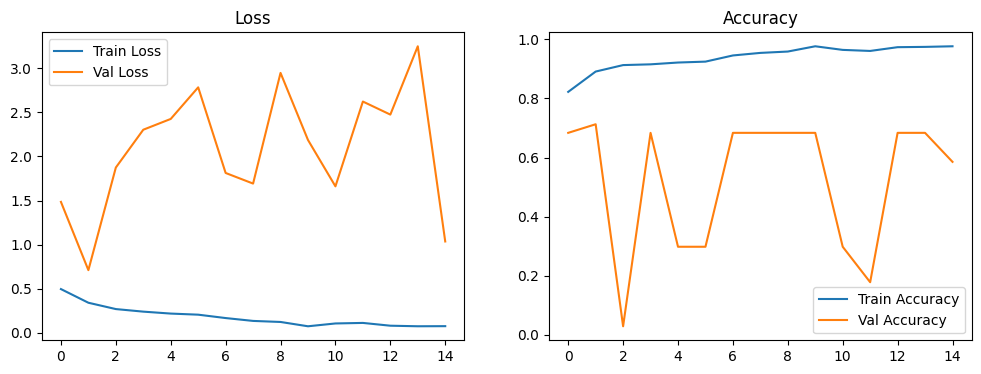

In [62]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()


## **Evaluate the Model on Test Data**

In [63]:
# Evaluate the Model on Test Data
model.load_weights('best_efficientnetv2_model.keras')
evaluation_metrics = model.evaluate(test_generator)

# Unpack metrics
test_loss, test_accuracy, test_precision, test_recall, test_auc = evaluation_metrics

# Print metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Generate Classification Report
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.6285 - auc: 0.7997 - loss: 0.8830 - precision: 0.6332 - recall: 0.3112
Test Loss: 0.8022
Test Accuracy: 0.6159
Test Precision: 0.7746
Test Recall: 0.3986
Test AUC: 0.8371
5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step 

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00         3
          RD       0.45      0.66      0.54        44
         ROP       0.76      0.62      0.68        91

    accuracy                           0.62       138
   macro avg       0.40      0.42      0.41       138
weighted avg       0.64      0.62      0.62       138



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Confusion Matrix**


Confusion Matrix:
[[ 0  0  3]
 [ 0 29 15]
 [ 0 35 56]]


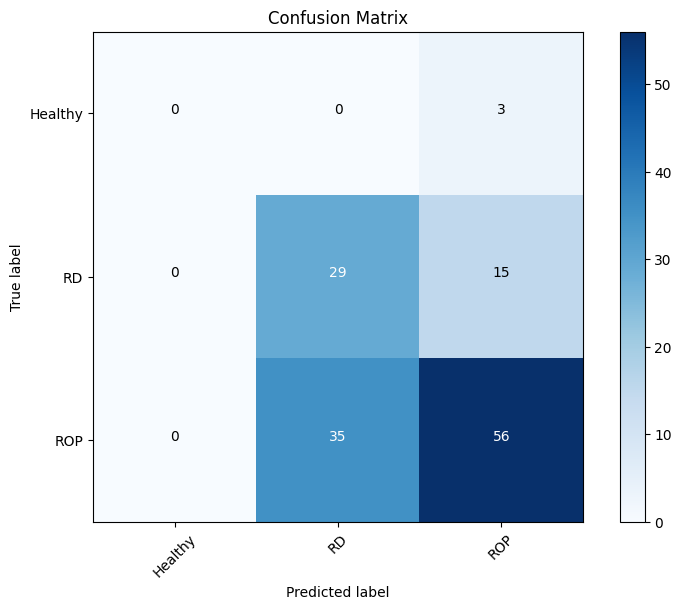

In [64]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [65]:
# Save the Model
#SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')

# Change the save directory to a writable location
SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

model_path = os.path.join(SAVE_DIR, 'efficientnetv2_rop_model_ha.h5')
model.save(model_path)

print(f"Model saved to {model_path}")

Model saved to /kaggle/working/saved_models/efficientnetv2_rop_model_ha.h5


# **ResNet50V2**

## **Import Libraries**

In [66]:
# Import Libraries and Set Random Seeds
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50  # Placeholder for ResNeXt-50
from keras.models import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


## **Dataset Paths and Parameters**

In [67]:
# Define dataset paths and parameters
BASE_DIR = '/kaggle/input/robo-dataset-h/robo_dataset_ha'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

## **Data Preprocessing and Augmentation**

In [68]:
# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1964 images belonging to 3 classes.
Found 275 images belonging to 3 classes.
Found 138 images belonging to 3 classes.


## **Function for Building Model**

In [69]:
# Build and Compile the Model
# Load ResNet50V2 
resnext_base = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Define the model
model = Sequential([
    resnext_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # Adjust the number of classes
])
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ]
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_8           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 23,540,739 (89.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

## **Train Model**

In [70]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_resnet50v2_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Train the Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.7577 - auc: 0.8951 - loss: 0.7536 - precision: 0.7754 - recall: 0.7508
Epoch 1: val_loss improved from inf to 0.80490, saving model to best_resnet50v2_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 117s 937ms/step - accuracy: 0.7583 - auc: 0.8954 - loss: 0.7523 - precision: 0.7758 - recall: 0.7514 - val_accuracy: 0.2982 - val_auc: 0.6236 - val_loss: 0.8049 - val_precision: 0.2982 - val_recall: 0.2982
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.8749 - auc: 0.9590 - loss: 0.3884 - precision: 0.8840 - recall: 0.8663
Epoch 2: val_loss did not improve from 0.80490
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 387ms/step - accuracy: 0.8751 - auc: 0.9591 - loss: 0.3879 - precision: 0.8842 - recall: 0.8665 - val_accuracy: 0.6836 - val_auc: 0.6923 - val_loss: 1.0728 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9072 - auc: 0.9747 - loss: 0.2994 - precision: 0.9090 - rec

## **Plot Training History**

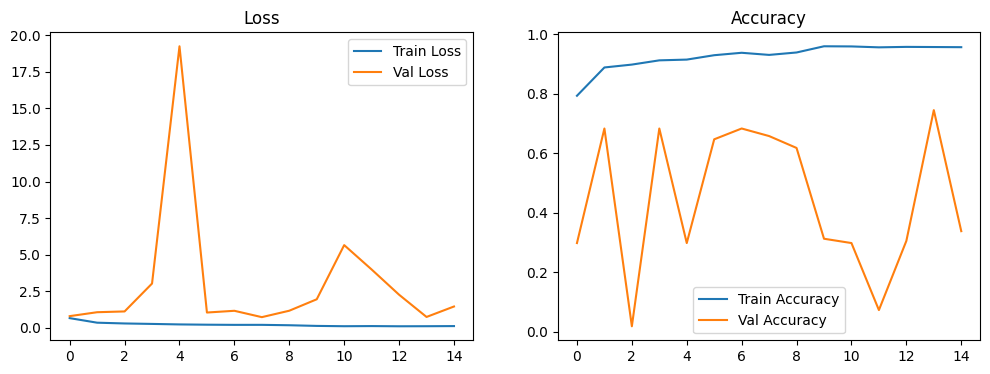

In [71]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## **Evaluate the Model on Test Data**

In [72]:
# Evaluate the Model on Test Data
model.load_weights('best_resnet50v2_model.keras')
evaluation_metrics = model.evaluate(test_generator)

# Unpack metrics
test_loss, test_accuracy, test_precision, test_recall, test_auc = evaluation_metrics

# Print metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Generate Classification Report
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 667ms/step - accuracy: 0.4758 - auc: 0.7126 - loss: 0.9013 - precision: 0.4758 - recall: 0.4259
Test Loss: 0.7627
Test Accuracy: 0.6449
Test Precision: 0.6613
Test Recall: 0.5942
Test AUC: 0.8174
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 803ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00         3
          RD       0.40      0.09      0.15        44
         ROP       0.66      0.93      0.78        91

    accuracy                           0.64       138
   macro avg       0.35      0.34      0.31       138
weighted avg       0.57      0.64      0.56       138



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Confusion Matrix**


Confusion Matrix:
[[ 0  0  3]
 [ 0  4 40]
 [ 0  6 85]]


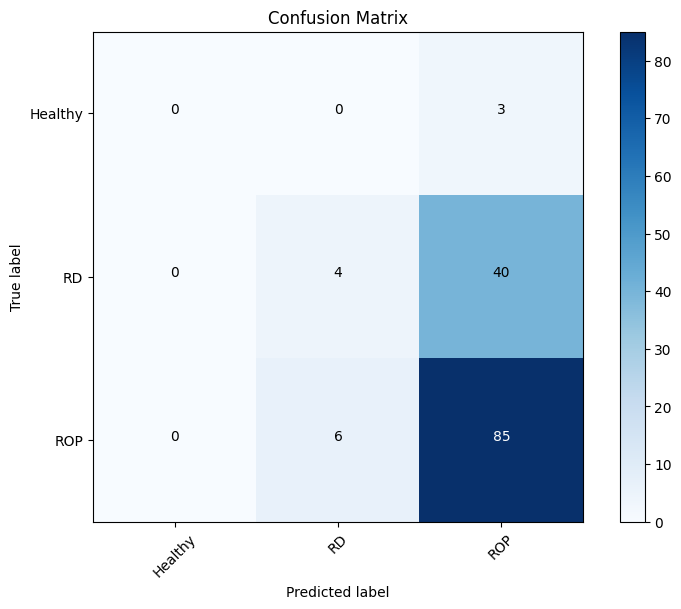

In [73]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Save the Model**

In [74]:
# Save the Model
#SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')

# Change the save directory to a writable location
SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

model_path = os.path.join(SAVE_DIR, 'resnet50v2_rop_model_ha.h5')
model.save(model_path)

print(f"Model saved to {model_path}")

Model saved to /kaggle/working/saved_models/resnet50v2_rop_model_ha.h5


# **ConvNeXt**

## **Import Libraries and Set Random Seeds**

In [75]:

# Import Libraries and Set Random Seeds
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ConvNeXtBase  # ConvNeXt model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


## **Dataset Paths and Parameters**

In [76]:
# Define dataset paths and parameters
BASE_DIR = '/kaggle/input/robo-dataset-h/robo_dataset_ha'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15


## **Data Preprocessing and Augmentation**

In [77]:
# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1964 images belonging to 3 classes.
Found 275 images belonging to 3 classes.
Found 138 images belonging to 3 classes.


## **Function for Building Models**

In [78]:
# Build and Compile the Model
# Load ConvNeXt model
convnext_base = ConvNeXtBase(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Define the model
model = Sequential([
    convnext_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # Adjust the number of classes
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ]
)

model.summary()


350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)           │ (None, 7, 7, 1024)          │      87,566,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,569,539 (334.05 MB)

 Trainable params: 87,569,539 (334.05 MB)

 Non-trainable params: 0 (0.00 B)

## **Train ConvNeXt**

In [79]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_convnext_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Train the Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6007 - auc: 0.7639 - loss: 1.6757 - precision: 0.6043 - recall: 0.5948
Epoch 1: val_loss improved from inf to 0.81562, saving model to best_convnext_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.6010 - auc: 0.7644 - loss: 1.6668 - precision: 0.6046 - recall: 0.5951 - val_accuracy: 0.2982 - val_auc: 0.6400 - val_loss: 0.8156 - val_precision: 0.2982 - val_recall: 0.2982
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.6475 - auc: 0.8180 - loss: 0.8185 - precision: 0.6493 - recall: 0.6245
Epoch 2: val_loss improved from 0.81562 to 0.72116, saving model to best_convnext_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 50s 760ms/step - accuracy: 0.6477 - auc: 0.8181 - loss: 0.8179 - precision: 0.6496 - recall: 0.6248 - val_accuracy: 0.6836 - val_auc: 0.8327 - val_loss: 0.7212 - val_precision: 0.6836 - val_recall: 0.6836
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.6797 - auc: 0.8296 - loss: 0

## **Plot Training History**

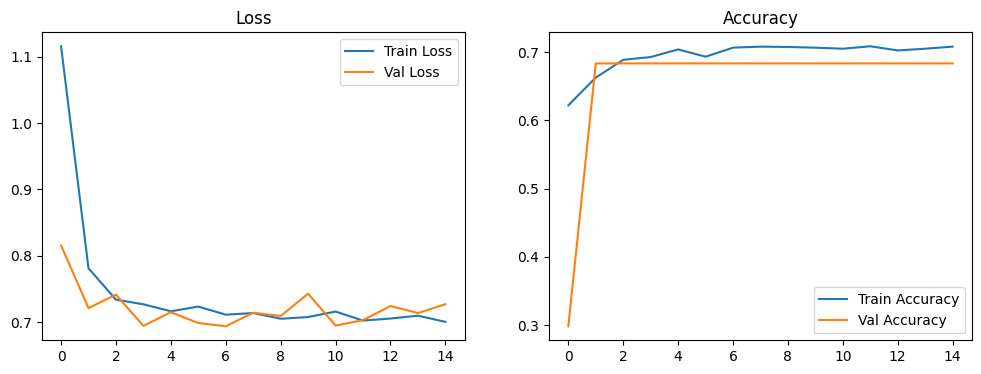

In [80]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

## **Generate Reports And Visualizations**

In [81]:
# Evaluate the Model on Test Data
model.load_weights('best_convnext_model.keras')
evaluation_metrics = model.evaluate(test_generator)

# Unpack metrics
test_loss, test_accuracy, test_precision, test_recall, test_auc = evaluation_metrics

# Print metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Generate Classification Report
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 970ms/step - accuracy: 0.4546 - auc: 0.7074 - loss: 0.9415 - precision: 0.4546 - recall: 0.4546        
Test Loss: 0.7234
Test Accuracy: 0.6594
Test Precision: 0.6594
Test Recall: 0.6594
Test AUC: 0.8188
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step 

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00         3
          RD       0.00      0.00      0.00        44
         ROP       0.66      1.00      0.79        91

    accuracy                           0.66       138
   macro avg       0.22      0.33      0.26       138
weighted avg       0.43      0.66      0.52       138



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Confusion Matrix**


Confusion Matrix:
[[ 0  0  3]
 [ 0  0 44]
 [ 0  0 91]]


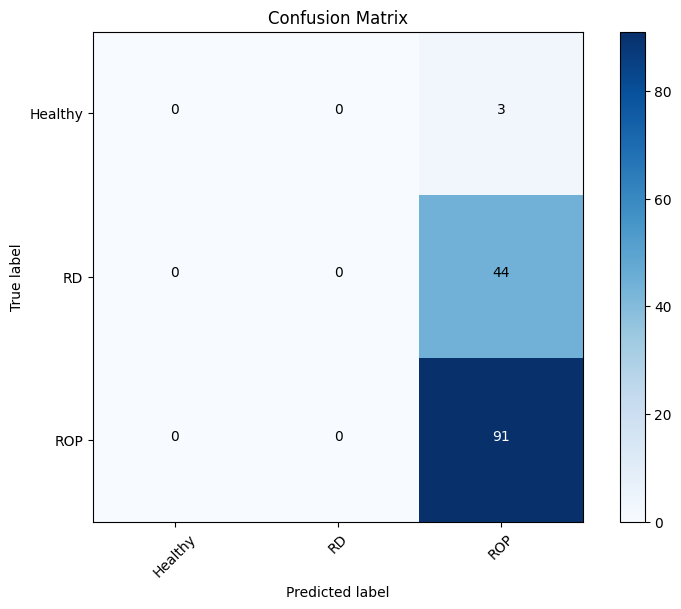

In [82]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


## **Save the Model**

In [83]:
# Save the Model
#SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')

# Change the save directory to a writable location
SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

model_path = os.path.join(SAVE_DIR, 'convnext_rop_model_ha.h5')
model.save(model_path)

print(f"Model saved to {model_path}")

Model saved to /kaggle/working/saved_models/convnext_rop_model_ha.h5
